# LMS Exploration | 5. AI measuring Similarity

---

**[Introduce]**
* 두 얼굴이 얼마나 닮았는지 유사도를 측정하는 AI 모델을 만들어보자
* 이번시간에는 본인의 얼굴이 어떤 연예인과 닮았는지 유사도를 측정해볼 것이다.
* 얼굴 이미지를 비교할 때, 고차원 정보를 저차원으로 변환하면서 필요한 정보를 보존하는 **임베딩 기법**을 활용할 수 있다.

**[Data]**
* 내얼굴 4장(무표정, 피곤한표정, 살짝웃는표정, 빵긋웃는표정으로 다양하게 준비했음)
* 연예인 사진 283장 (남녀노소, 배우, 가수, 개그맨, 운동선수 등 다양함)

**[Preparation]**  
* tar.xz 압축파일을 현재 폴더에 푸는 코드 : tar -xvf파일이름.tar.xz



---

## 1. Preparation

### 1-1. 이미지 파일 준비하기  
* 내 얼굴과 유사도를 측정할 연예인 폴더의 압축을 풀어줍니다.    
    다양한 연예인 이미지를 제공해주신 수희님께 감사드립니다 :)    


```os
root@wb3olflparel9bwqagowzdzvt-55c9b997cb-ptb57:~/aiffel/SimilarFace# tar - xvfcelebrity.tar.xz  

celebrity/  
celebrity/윤균상.jpg  
celebrity/이종석.jpeg  
celebrity/박해일.jpeg  
celebrity/이승철.jpeg 
```

### 1-2. 파일 확장자 변환
* 파일 사용을 용이하게 하기 위해서 jpeg, jpg, png로 다양했던 확장자를 모두 jpg로 변환해주었습니다.


```python
import glob  

files = glob.glob(dir_path+'/celebrity/*')  

for name in files:  
    print(name)    
    if not os.path.isdir(name):  
        src = os.path.splitext(name)  
        os.rename(name, src[0]+'.jpg')  
```      

In [1]:
#- 필요한 라이브러리 불러오기
import os
import face_recognition
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

## 2. define function | 함수 정의하기

* **face_recognition.api.load_image_file(file, mode='RGB')**  
Loads an image file (.jpg, .png, etc) into a numpy array  
Returns : image contents as numpy array
* **face_recognition.api.face_locations(img, number_of_times_to_upsample=1, model='hog')**  
Returns an array of bounding boxes of human faces in a image  
Returns : A list of tuples of found face locations in css (top, right, bottom, left) order

참고 : [face_recognition](https://face-recognition.readthedocs.io/en/latest/face_recognition.html)

### 2-1. detect & crop face

In [2]:
#- 임베딩 추출을 위해 얼굴 영역을 자르는 함수
#- cropped_face는 PIL 이미지로 변환하여 저장

def get_cropped_face(image_file): 
    
    image = face_recognition.load_image_file(image_file) #- 넘파이 배열로 이미지 로드
    face_locations = face_recognition.face_locations(image) #- 얼굴 영역의 넘파이 배열 반환
    a, b, c, d = face_locations[0]
    cropped_face = image[a:c,d:b,:]
    
    return cropped_face

* face detection이 잘 이루어지지 않는 경우에 발생하는 오류 처리하기

face detection이 잘 이뤄지지 않는 경우, face_locations 변수에는 빈 튜플리스트가 저장되고, get_face_embedding함수에서 오류가 나게됩니다. 이러한 오류 문제를 해결하기 위한 방법에는 여러가지가 있습니다.  


    채택한 방법 : get_face_embedding_dict 함수에서 try-except 문을 활용하여 get_face_embadding 함수에서 오류가 나는 경우엔 예외처리로 pass를 설정합니다.  
    
    첫번째 방법 : face_locations=[(0,0,0,0)] 할당  
    두번째 방법 : 그 이미지 지우기   
    세번째 방법 : face_locations 의 평균을 넣기 << 얼굴 위치가 제각각이어서 의미 없음  

### 2-2. face embedding

In [3]:
def get_face_embedding(face):
    return face_recognition.face_encodings(face)


def get_face_embedding_dict(dir_path):
    file_list = os.listdir(dir_path)
    embedding_dict = {}
     
    for file in file_list:
        img_path = os.path.join(dir_path, file)
        try:
            face = get_cropped_face(img_path)
            embedding = get_face_embedding(face)
            if len(embedding) > 0:  #- face detection이 잘 이뤄지지 않은 부분은 제외합니다. 
                embedding_dict[os.path.splitext(file)[0]] = embedding[0] #- 임베딩 사전에는 확장자를 제거한 파일이름을 저장합니다.
        except:
            pass
       
    return embedding_dict

### 2-3. Similarity

In [4]:
def get_distance(name1, name2): 
    return np.linalg.norm(embedding_dict[name1]-embedding_dict[name2], ord=2)

def get_sort_key_func(name1):
    def get_distance_from_name1(name2):
        return get_distance(name1, name2)
    return get_distance_from_name1

def get_nearest_face(name, top=5):
    sort_key_func = get_sort_key_func(name)
    sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))
    similar_face = {}
    for i in range(top+1):
        if i == 0 :   #- 첫번째로 나오는 이름은 자기 자신일 것이므로 제외합니다. 
            continue
        if sorted_faces[i]:
            print('순위 {} : 이름({}), 거리({})'.format(i, sorted_faces[i][0], sort_key_func(sorted_faces[i][0])))
            similar_face[sorted_faces[i][0]] = sort_key_func(sorted_faces[i][0]) 
    return similar_face

In [5]:
import cv2
def show_nearest_face(similar_face):
    fig = plt.figure()
    rows = 3
    cols = 2
    for i,(j,k) in enumerate(similar_face.items()):
        if i == 0:
            continue
            
        img = plt.imread(dir_path+'/celebrity/'+j+'.jpg')   
        ax = fig.add_subplot(rows, cols, i)
        ax.set_title(f'김은서와 {i}번째로 닮은 연예인은 {j}입니다')
        ax.axis('off')
        plt.show()
        fig.tight_layout() 

## 2. face recognition | 얼굴인식 
* 얼굴 임베딩을 구하기에 앞서, 이미지 속에서 얼굴 영역만을 정확히 인식하여 추출해 내야 합니다.  
* 이를 통해 얼굴의 특성을 반영하는 임베딩 벡터를 정확히 얻을 수 있습니다.  
* face_recognition 라이브러리를 불러와서 load image, detect face, crop face 등 다양한 메서드를 활용해보겠습니다~   

file_list: ['김은서0.jpg', '김은서3.jpg', '김은서1.jpg', '김은서2.jpg']


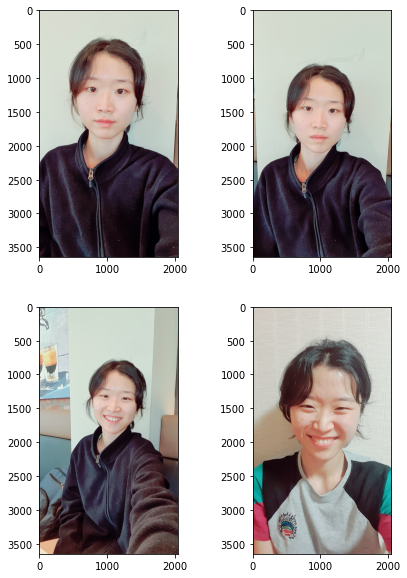

In [6]:
dir_path = os.getenv('HOME')+'/aiffel/SimilarFace' #- 내얼굴 이미지파일이 들어있는 폴더
file_list = os.listdir(dir_path+'/me') #- 내얼굴 이미지파일 리스트 

print ("file_list: {}".format(file_list)) #- 불러온 파일 리스트 확인

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7,10))

for i, ax in enumerate(axes.flatten()): #- 파일 이미지 확인하기
    image = face_recognition.load_image_file(dir_path+'/me/'+file_list[i])
    ax.imshow(image)

plt.show()
fig.tight_layout()

## 3. detect & crop & embed face

/aiffel/aiffel/SimilarFace/my_cropped_face/김은서0.jpg 저장완료!
/aiffel/aiffel/SimilarFace/my_cropped_face/김은서3.jpg 저장완료!
/aiffel/aiffel/SimilarFace/my_cropped_face/김은서1.jpg 저장완료!
/aiffel/aiffel/SimilarFace/my_cropped_face/김은서2.jpg 저장완료!


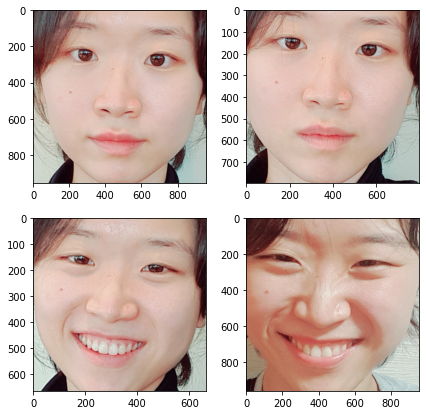

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7,7))

for i, ax in enumerate(axes.flatten()):
    cropped_face = get_cropped_face(dir_path+'/me/'+file_list[i])
    ax.imshow(cropped_face)
    
    #- cropped_face를 PIL 이미지로 변환하여 저장하기
    pillow_image = Image.fromarray(cropped_face) 
    
    pillow_image.save(dir_path+'/my_cropped_face/'+file_list[i])    
    print("{} 저장완료!".format(dir_path+'/my_cropped_face/'+file_list[i]))
    
    #- 얼굴 영역의 임베딩 추출하기
embedding = get_face_embedding(cropped_face)
embedding_dict = get_face_embedding_dict(dir_path+'/me')

## 4. 유사도 측정하기

In [8]:
get_nearest_face('김은서0', 3)

순위 1 : 이름(김은서3), 거리(0.16834623852432945)
순위 2 : 이름(김은서1), 거리(0.2397428642290488)
순위 3 : 이름(김은서2), 거리(0.3114067749831206)


{'김은서3': 0.16834623852432945,
 '김은서1': 0.2397428642290488,
 '김은서2': 0.3114067749831206}

## 5. 본격 ! 내 얼굴이 어떤 연예인과 닮았는지 알아보기

### 5-1. preparation

In [9]:
dir_path = os.getenv('HOME')+'/aiffel/SimilarFace' 
file_list = os.listdir(dir_path+'/celebrity') #- 연예인 이미지파일 리스트 
print ("file_list: {}".format(file_list)) #- 불러온 파일 리스트 확인

file_list: ['김상호.jpg', '벤 에플렉.jpg', '이대형.jpg', '이근대위.jpg', '이명박.jpg', '이희준.jpg', '류승범.jpg', '유재석.jpg', '손흥민.jpg', '매드클라운.jpg', '홍구.jpg', '곽도원.jpg', '박찬호.jpg', '손예진.jpg', '디오.jpg', '도아.jpg', '정수빈.jpg', '티파니.jpg', '최민식.jpg', '박보검.jpg', '박완규.jpg', '윤균상.jpg', '리암 니슨.jpg', '박휘순.jpg', '이범수.jpg', '정국.jpg', '신태용.jpg', '효정.jpg', '사쿠라.jpg', '찬열.jpg', '크리스 에반스.jpg', '티모시 달튼.jpg', '박보영.jpg', '로저 무어.jpg', '솔라.jpg', '황병국.jpg', '시우민.jpg', '존 파브르.jpg', '류승룡.jpg', '잭 니콜슨.jpg', '이진호.jpg', '정형돈.jpg', '차명석.jpg', '박나래.jpg', '전소미.jpg', '무라니시.jpg', '레드벨벳웬디.jpg', '윤종신.jpg', '이말년.jpg', '첸.jpg', '슬리피.jpg', '신동엽.jpg', '트와이스나연.jpg', '김고은.jpg', '슈가.jpg', '이승철.jpg', '슈퍼비.jpg', '이성민.jpg', '트와이스다현.jpg', '다니엘 크레이그.jpg', '잇섭.jpg', '이천수.jpg', '브래들리 쿠퍼.jpg', '러블리즈예인.jpg', '주진모(올드).jpg', '유노윤호.jpg', '도지한.jpg', '잇지유나.jpg', '김종서.jpg', '윤도현.jpg', '이영하.jpg', '손호준.jpg', '톰 홀랜드.jpg', '켄 정.jpg', '대도서관.jpg', '신비.jpg', '줄리엔강.jpg', '김민재.jpg', '길.jpg', '조이.jpg', '로제.jpg', '민니.jpg', '이승환.jpg', '장도연.jpg', '유해진.jpg', '아이즈원민주.jpg', '조승우

### 5-2. load images

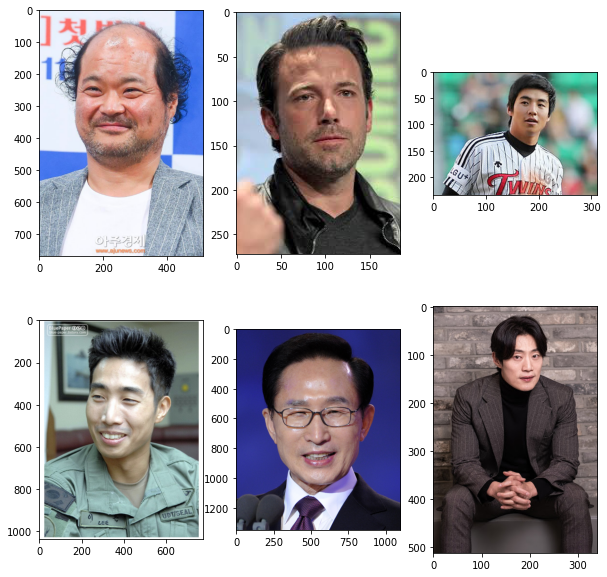

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,10))

for i, ax in enumerate(axes.flatten()): #- 파일 이미지 확인하기
    image = face_recognition.load_image_file(dir_path+'/celebrity/'+file_list[i])
    
    ax.imshow(image)

plt.show()
fig.tight_layout()

In [11]:
print(len(file_list))

283


### 5-3. detect & crop & embed face

In [12]:
for i, file in enumerate(file_list):
    try:
        cropped_face = get_cropped_face(dir_path+'/celebrity/'+file)
        pillow_image = Image.fromarray(cropped_face) 
    
        pillow_image.save(dir_path+'/cropped_face/'+file)    
        print("{} 저장완료!".format(dir_path+'/cropped_face/'+file))
    
    except: 
              print(i, file)

embedding_dict = get_face_embedding_dict(dir_path+'/celebrity')

/aiffel/aiffel/SimilarFace/cropped_face/김상호.jpg 저장완료!
/aiffel/aiffel/SimilarFace/cropped_face/벤 에플렉.jpg 저장완료!
/aiffel/aiffel/SimilarFace/cropped_face/이대형.jpg 저장완료!
/aiffel/aiffel/SimilarFace/cropped_face/이근대위.jpg 저장완료!
/aiffel/aiffel/SimilarFace/cropped_face/이명박.jpg 저장완료!
/aiffel/aiffel/SimilarFace/cropped_face/이희준.jpg 저장완료!
/aiffel/aiffel/SimilarFace/cropped_face/류승범.jpg 저장완료!
/aiffel/aiffel/SimilarFace/cropped_face/유재석.jpg 저장완료!
/aiffel/aiffel/SimilarFace/cropped_face/손흥민.jpg 저장완료!
/aiffel/aiffel/SimilarFace/cropped_face/매드클라운.jpg 저장완료!
/aiffel/aiffel/SimilarFace/cropped_face/홍구.jpg 저장완료!
/aiffel/aiffel/SimilarFace/cropped_face/곽도원.jpg 저장완료!
/aiffel/aiffel/SimilarFace/cropped_face/박찬호.jpg 저장완료!
/aiffel/aiffel/SimilarFace/cropped_face/손예진.jpg 저장완료!
/aiffel/aiffel/SimilarFace/cropped_face/디오.jpg 저장완료!
/aiffel/aiffel/SimilarFace/cropped_face/도아.jpg 저장완료!
/aiffel/aiffel/SimilarFace/cropped_face/정수빈.jpg 저장완료!
/aiffel/aiffel/SimilarFace/cropped_face/티파니.jpg 저장완료!
/aiffel/aiffel/SimilarFace

### 5-5. 나와 가장 닮은 연예인은??

In [13]:
my_nearest_face = get_nearest_face('김은서0', 5)

순위 1 : 이름(정수빈), 거리(0.3656937945663996)
순위 2 : 이름(유리), 거리(0.3926421238091161)
순위 3 : 이름(박건우), 거리(0.3932206126565758)
순위 4 : 이름(정준하), 거리(0.39803343591287443)
순위 5 : 이름(안재홍), 거리(0.40335474688675055)


## 6. 유사도 측정 시각화하기

In [14]:
target_path = os.path.join(dir_path, 'cropped_face')

In [15]:
print(target_path)

/aiffel/aiffel/SimilarFace/cropped_face


<function matplotlib.pyplot.show(close=None, block=None)>

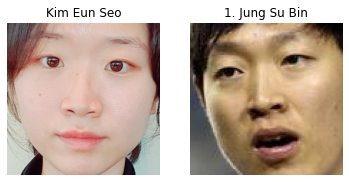

In [29]:
fig = plt.figure()
rows = 1
cols = 2

me = Image.open(target_path+'/김은서0.jpg')
him = Image.open(target_path+'/정수빈.jpg')

ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(me)
ax1.set_title('Kim Eun Seo')
ax1.axis('off')

ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(him)
ax2.set_title('1. Jung Su Bin')
ax2.axis('off')

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

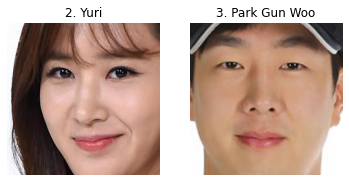

In [30]:
fig = plt.figure()
rows = 1
cols = 2

a = Image.open(target_path+'/유리.jpg')
b = Image.open(target_path+'/박건우.jpg')

ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(a)
ax1.set_title('2. Yuri')
ax1.axis('off')

ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(b)
ax2.set_title('3. Park Gun Woo')
ax2.axis('off')

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

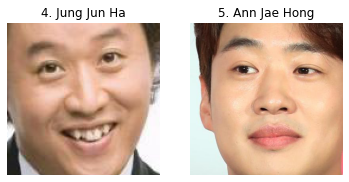

In [31]:
fig = plt.figure()
rows = 1
cols = 2

a = Image.open(target_path+'/정준하.jpg')
b = Image.open(target_path+'/안재홍.jpg')

ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(a)
ax1.set_title('4. Jung Jun Ha')
ax1.axis('off')

ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(b)
ax2.set_title('5. Ann Jae Hong')
ax2.axis('off')

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

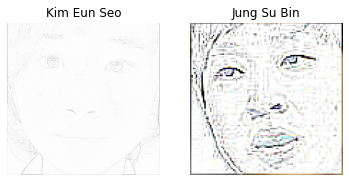

In [45]:
from PIL import Image, ImageFilter

fig = plt.figure()
rows = 1
cols = 2

ax1 = fig.add_subplot(rows, cols, 1)
blurImage = me.filter(ImageFilter.CONTOUR)
ax1.imshow(blurImage)
ax1.set_title('Kim Eun Seo')
ax1.axis('off')

ax2 = fig.add_subplot(rows, cols, 2)
blurImage = him.filter(ImageFilter.CONTOUR)
ax2.imshow(blurImage)
ax2.set_title('Jung Su Bin')
ax2.axis('off')

plt.show

## 7. 자가평가
```
야구선수 정수빈이 나와 가장 닮았다는 결과가 나와서 뜻밖이었다.. (여자 연예인이 나올 거라 당연히 믿었다..) 
그런데 cropped_face 사진으로 비교해보니, AI의 눈썰미가 새삼 놀라웠다..
(닮았다..)
물론 간단한 수학적 거리 연산을 통한 유사도를 예측한 것이지만,
닮은 얼굴을 꽤나 잘 찾아낸 것 같다
```